In [1]:
import pandas as pd
import re
import string
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
import emoji

# Load the dataset
dataframe1 = pd.read_csv("depress_text.csv", index_col=0)
dataframe2 = pd.read_csv("non_depress_text.csv", index_col=0)

# Gabungkan kedua DataFrame
data = pd.concat([dataframe1, dataframe2])

# Reset the index of the DataFrame
data = data.reset_index()

# Data Cleaning
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text):
    # Remove double quotation marks
    text = text.replace('"', '')
    # Remove RT tags
    text = re.sub(r'^RT[\s]+', '', text)
    # Remove user tags (@Usertag)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove URLs
    text = re.sub(r'https?:\/\/\S+', '', text)
    # Remove hashtags and keep only the text
    text = re.sub(r'#', '', text)
    # Remove emojis
    text = emoji.demojize(text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Remove word repetition
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text)
    # Handle contractions
    text = contractions.fix(text)
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords, perform stemming and lemmatization
    tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    return text

data['Cleaned_Text'] = data['Text'].apply(clean_text)

# Separate the features (text) and labels (sentiment)
X = data['Cleaned_Text']
y = data['Sentiment']

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Pipeline for Data Processing and Modeling
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), min_df=2, max_df=0.8, max_features=5000)),
    ('feature_selection', SelectKBest(score_func=chi2, k='all')),
    ('model', LinearSVC())
])

# Hyperparameter Tuning using GridSearchCV
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [1000, 5000, 10000],
    'model__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, error_score='raise')
grid_search.fit(X_train, y_train)

# Best Model and Parameters
best_model = grid_search.best_estimator_
best_parameters = grid_search.best_params_

print("Best Model:", best_model)
print("Best Parameters:", best_parameters)

# Make Predictions on the Test Set
y_pred = best_model.predict(X_test)

# Calculate Accuracy
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy)


Best Model: Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=5000, min_df=2,
                                 ngram_range=(1, 3))),
                ('feature_selection',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x000001F04A3C1580>)),
                ('model', LinearSVC(C=1))])
Best Parameters: {'model__C': 1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 3)}
Accuracy: 0.9896907216494846


In [2]:
# Replace 'your_text' with the actual text to predict
text_to_predict = 'I am very depress.'

# Clean the text
cleaned_text = clean_text(text_to_predict)

# Vectorize the cleaned text
text_vectorized = best_model.named_steps['tfidf'].transform([cleaned_text])

# Make the prediction
prediction = best_model.named_steps['model'].predict(text_vectorized)

# Map the prediction to the corresponding label
if prediction[0] == 0:
    result = "Not Depressed"
else:
    result = "Depressed"

# Print the prediction result
print("Prediction:", result)


Prediction: Depressed


In [3]:
from sklearn.metrics import classification_report

# Evaluate the model on the test set
classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       180
           1       0.98      1.00      0.99       208

    accuracy                           0.99       388
   macro avg       0.99      0.99      0.99       388
weighted avg       0.99      0.99      0.99       388



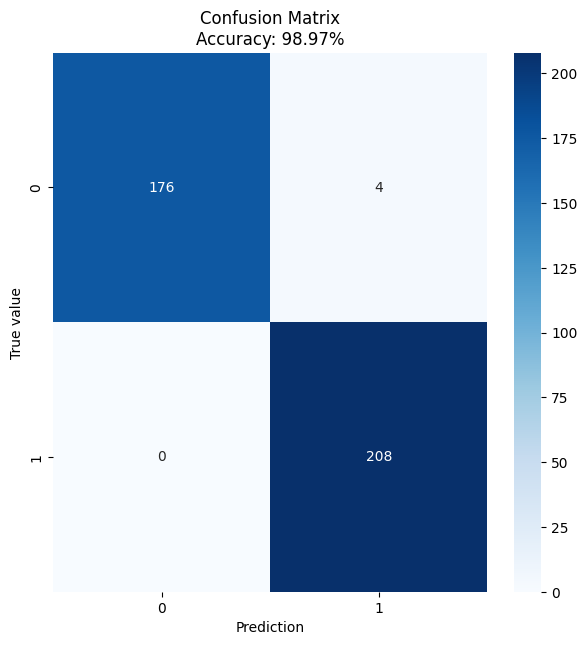

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       180
           1       0.98      1.00      0.99       208

    accuracy                           0.99       388
   macro avg       0.99      0.99      0.99       388
weighted avg       0.99      0.99      0.99       388



In [4]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def plot_confusion(cm, accuracy):
    plt.figure(figsize=(7, 7))
    sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
    plt.xlabel("Prediction")
    plt.ylabel("True value")
    plt.title(f"Confusion Matrix\nAccuracy: {accuracy*100:.2f}%")
    plt.show()

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Display the confusion matrix with accuracy
plot_confusion(confusion_mat, accuracy)

# Display the classification report
classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)


In [5]:
from sklearn.metrics import classification_report

# Calculate the classification report
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Extract TP, TN, FP, FN from the classification report dictionary
TP = classification_rep['1']['precision']
TN = classification_rep['0']['precision']
FP = classification_rep['1']['recall']
FN = classification_rep['0']['recall']

print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)


True Positives (TP): 0.9811320754716981
True Negatives (TN): 1.0
False Positives (FP): 1.0
False Negatives (FN): 0.9777777777777777


In [6]:
# Function to identify words or tokens indicating depressive symptoms
def identify_depressive_words(text):
    # Clean the text
    cleaned_text = clean_text(text)

    # Vectorize the cleaned text
    text_vectorized = best_model.named_steps['tfidf'].transform([cleaned_text])

    # Access the feature names from the TfidfVectorizer vocabulary
    feature_names = best_model.named_steps['tfidf'].get_feature_names_out()

    # Access the coefficients from the best_model
    coefficients = best_model.named_steps['model'].coef_

    # Create a dictionary to store the coefficients and their corresponding feature names
    coefficients_dict = {feature_names[i]: coefficients[0, i] for i in range(len(feature_names))}

    # Sort the coefficients dictionary based on their values
    sorted_coefficients = sorted(coefficients_dict.items(), key=lambda x: x[1], reverse=True)

    # Extract the top N words or tokens indicating depressive symptoms
    top_n = 10  # Adjust the value of N as needed
    top_n_words = [word for word, coef in sorted_coefficients[:top_n]]

    # Highlight the depressive words in the cleaned text
    highlighted_text = cleaned_text
    for word in top_n_words:
        highlighted_text = highlighted_text.replace(word, f"**{word.upper()}**")

    return highlighted_text

# Replace 'your_text' with the actual text to predict
text_to_predict = input("Enter the text to predict: ")

# Identify depressive words in the user's input and highlight them
highlighted_text = identify_depressive_words(text_to_predict)

print("Highlighted text:")
print(highlighted_text)

Highlighted text:
bla


In [7]:
# Replace 'your_text' with the actual text to predict
text_to_predict = input("Enter the text to predict: ")

# Identify depressive words in the user's input
depressive_words = identify_depressive_words(text_to_predict)

if depressive_words:
    print("Words indicating depressive symptoms:")
    print(depressive_words)
else:
    print("No words indicating depressive symptoms.")


Words indicating depressive symptoms:
bla
